In [1]:
import os
import ast
import csv
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append(os.path.join(os.getcwd(), 'src'))
import config   

# Note:     (kl loss) 0 <= alpha <= 1 (next_token loss)

In [2]:
# CSV FILE LOADING CONFIGURATION

# Option 1: Load single CSV file (current directory)
single_csv_file = "CSV_metrics.csv"

# Option 2: Load multiple CSV files from directories
# Copy/paste full directory paths here, one per line:
csv_directories = [
    "/home/klambert/projects/aip-craffel/klambert/SLMensembles/",  # Current directory
    "/scratch/klambert/model_log/single_logs/alpha0-20250825-184001-aa97bff-qwen0p5b-a0-t1-lr0p00015",
    # "/path/to/experiment2/outputs", 
    # "/path/to/experiment3/outputs",
]

# CSV filename patterns to look for in each directory
csv_patterns = ["CSV_metrics.csv", "metrics.csv", "results.csv"]

# Exclude specific directories/files
exclude_patterns = []

# =============================================================================

# Load CSV files
load_multiple = len(csv_directories) > 1 or any(d != "/home/klambert/projects/aip-craffel/klambert/SLMensembles" for d in csv_directories)

all_dfs = []
dfs = {}

if load_multiple:
    print(f"Loading CSV files from {len(csv_directories)} directories...")
    
    for dir_path in csv_directories:
        if not os.path.exists(dir_path):
            print(f"Warning: Directory does not exist: {dir_path}")
            continue
            
        # Check if any exclude patterns match
        if any(exc in dir_path for exc in exclude_patterns):
            print(f"Skipping excluded directory: {dir_path}")
            continue
            
        found_csv = False
        for pattern in csv_patterns:
            csv_file = os.path.join(dir_path, pattern)
            if os.path.exists(csv_file):
                try:
                    df = pd.read_csv(csv_file, low_memory=False)
                    
                    # Create a meaningful source name from the directory path
                    source_name = os.path.basename(dir_path) or os.path.basename(os.path.dirname(dir_path))
                    if source_name in dfs:  # Handle duplicate names
                        source_name = f"{source_name}_{len([k for k in dfs.keys() if k.startswith(source_name)])}"
                    
                    df["source"] = source_name
                    df["full_path"] = dir_path
                    
                    dfs[source_name] = df
                    all_dfs.append(df)
                    
                    print(f"  ✓ Loaded {len(df)} rows from {csv_file} as '{source_name}'")
                    found_csv = True
                    break
                except Exception as e:
                    print(f"  ✗ Error loading {csv_file}: {e}")
                    
        if not found_csv:
            print(f"  ✗ No CSV files found in {dir_path} (patterns: {csv_patterns})")
else:
    # Load single CSV file
    print(f"Loading single CSV file: {single_csv_file}")
    
    if os.path.exists(single_csv_file):
        try:
            df = pd.read_csv(single_csv_file, low_memory=False)
            df["source"] = "current_run"
            df["full_path"] = os.getcwd()
            
            dfs = {"current_run": df}
            all_dfs = [df]
            
            print(f"  ✓ Loaded {len(df)} rows from {single_csv_file}")
        except Exception as e:
            print(f"  ✗ Error loading {single_csv_file}: {e}")
            dfs = {}
            all_dfs = []
    else:
        print(f"  ✗ File not found: {single_csv_file}")
        dfs = {}
        all_dfs = []

# Combine all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    sources = list(dfs.keys())
    print(f"\n📊 Total: {len(combined_df)} rows from {len(all_dfs)} files")
    print(f"📁 Sources: {sources}")
else:
    print("\n❌ No CSV files loaded!")
    combined_df = pd.DataFrame()
    sources = []

Loading CSV files from 2 directories...
  ✓ Loaded 25866 rows from /home/klambert/projects/aip-craffel/klambert/SLMensembles/CSV_metrics.csv as 'SLMensembles'

📊 Total: 25866 rows from 1 files
📁 Sources: ['SLMensembles']


In [3]:
cmap = plt.get_cmap('inferno')

# Create color mapping after sources are loaded
if sources:
    color_map = {source: cmap(0.8 * i / max(1, len(sources) - 1)) for i, source in enumerate(sources)}
else:
    color_map = {}
color_map["default"] = "black"


=== Plotting Training Loss ===


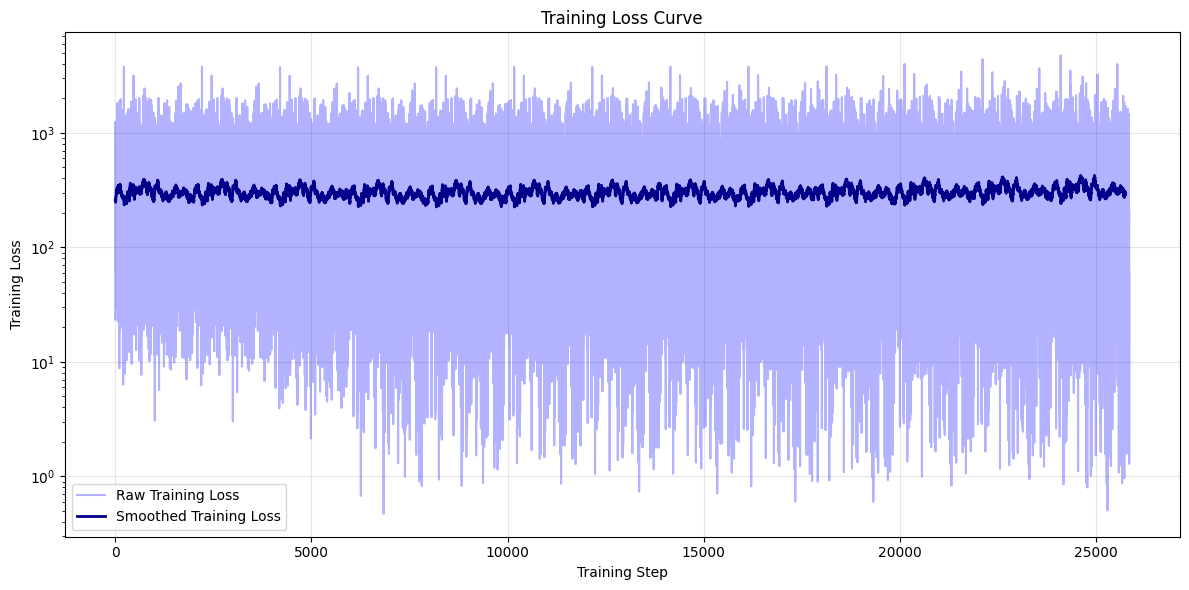

Plotted training loss for 1 source(s)


In [4]:

# 1) Student Training Loss Curve
print("\n=== Plotting Training Loss ===")

filter_size = 101
kernel = np.ones(filter_size) / filter_size

# Extract training loss data - convert tensor strings to float
student_train_df = df[
    (df["role"] == "student") & 
    (df["phase"] == "train") & 
    (df["function"] == "train_step") &
    (df["train_loss"].notna())
].copy()

if len(student_train_df) > 0:
    # Convert train_loss from tensor strings to numeric values
    train_loss_values = []
    for val in student_train_df["train_loss"]:
        if pd.isna(val):
            continue
        try:
            if isinstance(val, str) and "tensor(" in val:
                # Extract float from tensor string like "tensor(23.4249, device='cuda:0')"
                import re
                match = re.search(r'tensor\(([0-9.]+)', val)
                if match:
                    train_loss_values.append(float(match.group(1)))
            else:
                train_loss_values.append(float(val))
        except (ValueError, AttributeError):
            continue
    
    if len(train_loss_values) > filter_size:
        train_loss_array = np.array(train_loss_values)
        smoothed = scipy.signal.fftconvolve(train_loss_array, kernel, mode="valid")
        
        plt.figure(figsize=(12, 6))
    
        if len(sources) == 1:
            # Single source - simple plot
            plt.plot(range(len(train_loss_array)), train_loss_array, alpha=0.3, label="Raw Training Loss", color="blue")
            plt.plot(range(len(smoothed)), smoothed, label="Smoothed Training Loss", color="darkblue", linewidth=2)
        else:
            # Multiple sources - plot each separately
            for name, source_df in dfs.items():
                source_train_df = source_df[
                    (source_df["role"] == "student") & 
                    (source_df["phase"] == "train") & 
                    (source_df["function"] == "train_step") &
                    (source_df["train_loss"].notna())
                ]
                
                if len(source_train_df) > 0:
                    source_train_values = []
                    for val in source_train_df["train_loss"]:
                        if pd.isna(val):
                            continue
                        try:
                            if isinstance(val, str) and "tensor(" in val:
                                match = re.search(r'tensor\(([0-9.]+)', val)
                                if match:
                                    source_train_values.append(float(match.group(1)))
                            else:
                                source_train_values.append(float(val))
                        except (ValueError, AttributeError):
                            continue
                    
                    if len(source_train_values) > filter_size:
                        source_array = np.array(source_train_values)
                        source_smoothed = scipy.signal.fftconvolve(source_array, kernel, mode="valid")
                        color = color_map.get(name, color_map["default"])
                        plt.plot(range(len(source_array)), source_array, alpha=0.2, color=color)
                        plt.plot(range(len(source_smoothed)), source_smoothed, label=f"{name}", color=color, linewidth=2)
        
        plt.title("Training Loss Curve")
        plt.xlabel("Training Step")
        plt.ylabel("Training Loss")
        plt.yscale("log")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print(f"Plotted training loss for {len(sources)} source(s)")
    else:
        print(f"Not enough training loss data: {len(train_loss_values)} values")
else:
    print("No training loss data found")

In [5]:


# 2) Student Eval (New Token) Loss Curve  
print("\n=== Plotting Eval Loss ===")

# Extract evaluation loss data - look for rows with eval_loss values
student_eval_df = combined_df[
    (combined_df["role"] == "student") & 
    (combined_df["eval_loss"].notna())
].copy()

if len(student_eval_df) > 0:
    # Convert eval_loss values to numeric
    eval_loss_values = []
    for val in student_eval_df["eval_loss"]:
        if pd.isna(val):
            continue
        try:
            if isinstance(val, str) and "tensor(" in val:
                # Extract float from tensor string
                import re
                match = re.search(r'tensor\(([0-9.]+)', val)
                if match:
                    eval_loss_values.append(float(match.group(1)))
            else:
                eval_loss_values.append(float(val))
        except (ValueError, AttributeError):
            continue
    
    if len(eval_loss_values) > filter_size:
        eval_loss_array = np.array(eval_loss_values)
        smoothed = scipy.signal.fftconvolve(eval_loss_array, kernel, mode="valid")
        
        plt.figure(figsize=(12, 6))
    
        if len(sources) == 1:
            # Single source - simple plot
            plt.plot(range(len(eval_loss_array)), eval_loss_array, alpha=0.3, label="Raw Eval Loss", color="green")
            plt.plot(range(len(smoothed)), smoothed, label="Smoothed Eval Loss", color="darkgreen", linewidth=2)
        else:
            # Multiple sources - plot each separately
            for name, source_df in dfs.items():
                source_eval_df = source_df[
                    (source_df["role"] == "student") & 
                    (source_df["eval_loss"].notna())
                ]
                
                if len(source_eval_df) > 0:
                    source_eval_values = []
                    for val in source_eval_df["eval_loss"]:
                        if pd.isna(val):
                            continue
                        try:
                            if isinstance(val, str) and "tensor(" in val:
                                match = re.search(r'tensor\(([0-9.]+)', val)
                                if match:
                                    source_eval_values.append(float(match.group(1)))
                            else:
                                source_eval_values.append(float(val))
                        except (ValueError, AttributeError):
                            continue
                    
                    if len(source_eval_values) > filter_size:
                        source_array = np.array(source_eval_values)
                        source_smoothed = scipy.signal.fftconvolve(source_array, kernel, mode="valid")
                        color = color_map.get(name, color_map["default"])
                        plt.plot(range(len(source_array)), source_array, alpha=0.2, color=color)
                        plt.plot(range(len(source_smoothed)), source_smoothed, label=f"{name}", color=color, linewidth=2)
        
        # Add baseline if available
        baseline_teacher_loss = 0.7968094515065487
        plt.axhline(baseline_teacher_loss, color="black", linestyle="--", linewidth=2,
                    label=f"Teacher Baseline ({baseline_teacher_loss:.3f})")
        
        plt.title("Evaluation (New Token) Loss Curve")
        plt.xlabel("Evaluation Step")
        plt.ylabel("Evaluation Loss")
        plt.yscale("log")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print(f"Plotted evaluation loss for {len(sources)} source(s)")
    else:
        print(f"Not enough evaluation loss data: {len(eval_loss_values)} values")
else:
    print("No evaluation loss data found")


=== Plotting Eval Loss ===
Not enough evaluation loss data: 13 values



=== Plotting KL Loss ===


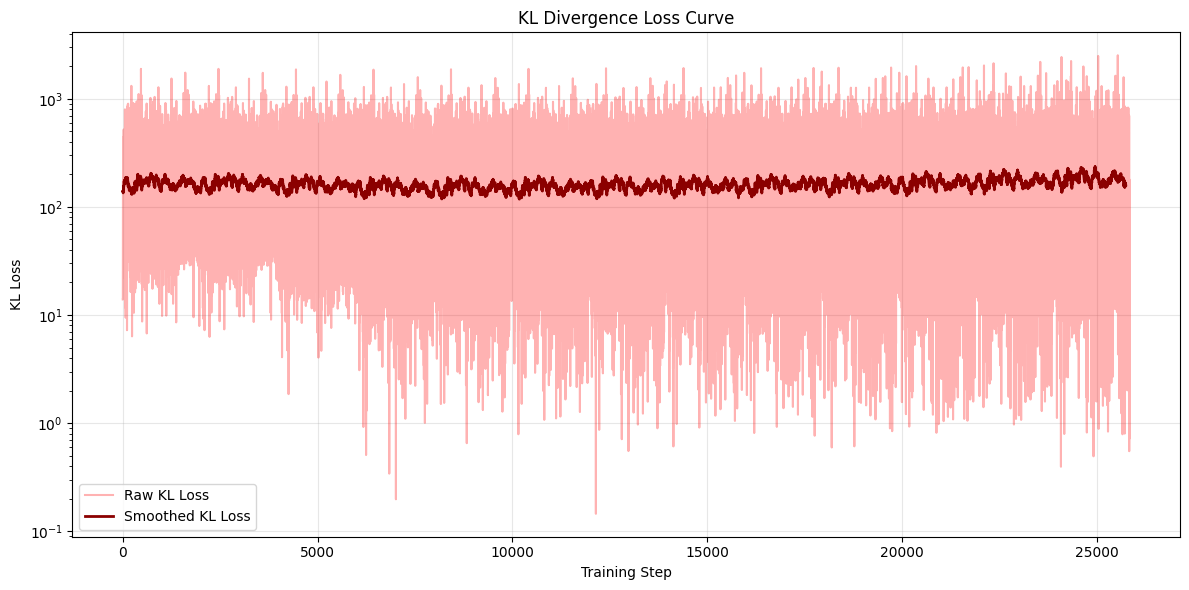

Plotted KL loss for 1 source(s)


In [6]:


# 3) Student Training KL Loss Curve
print("\n=== Plotting KL Loss ===")

# Extract training KL loss data
student_kl_df = combined_df[
    (combined_df["role"] == "student") & 
    (combined_df["train_kl_loss"].notna())
].copy()

if len(student_kl_df) > 0:
    # Convert train_kl_loss values to numeric
    kl_loss_values = []
    for val in student_kl_df["train_kl_loss"]:
        if pd.isna(val):
            continue
        try:
            if isinstance(val, str) and "tensor(" in val:
                # Extract float from tensor string
                import re
                match = re.search(r'tensor\(([0-9.]+)', val)
                if match:
                    kl_loss_values.append(float(match.group(1)))
            else:
                kl_loss_values.append(float(val))
        except (ValueError, AttributeError):
            continue
    
    if len(kl_loss_values) > filter_size:
        kl_loss_array = np.array(kl_loss_values)
        smoothed = scipy.signal.fftconvolve(kl_loss_array, kernel, mode="valid")
        
        plt.figure(figsize=(12, 6))
    
        if len(sources) == 1:
            # Single source - simple plot
            plt.plot(range(len(kl_loss_array)), kl_loss_array, alpha=0.3, label="Raw KL Loss", color="red")
            plt.plot(range(len(smoothed)), smoothed, label="Smoothed KL Loss", color="darkred", linewidth=2)
        else:
            # Multiple sources - plot each separately
            for name, source_df in dfs.items():
                source_kl_df = source_df[
                    (source_df["role"] == "student") & 
                    (source_df["train_kl_loss"].notna())
                ]
                
                if len(source_kl_df) > 0:
                    source_kl_values = []
                    for val in source_kl_df["train_kl_loss"]:
                        if pd.isna(val):
                            continue
                        try:
                            if isinstance(val, str) and "tensor(" in val:
                                match = re.search(r'tensor\(([0-9.]+)', val)
                                if match:
                                    source_kl_values.append(float(match.group(1)))
                            else:
                                source_kl_values.append(float(val))
                        except (ValueError, AttributeError):
                            continue
                    
                    if len(source_kl_values) > filter_size:
                        source_array = np.array(source_kl_values)
                        source_smoothed = scipy.signal.fftconvolve(source_array, kernel, mode="valid")
                        color = color_map.get(name, color_map["default"])
                        plt.plot(range(len(source_array)), source_array, alpha=0.2, color=color)
                        plt.plot(range(len(source_smoothed)), source_smoothed, label=f"{name}", color=color, linewidth=2)
        
        plt.title("KL Divergence Loss Curve")
        plt.xlabel("Training Step")
        plt.ylabel("KL Loss")
        plt.yscale("log")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print(f"Plotted KL loss for {len(sources)} source(s)")
    else:
        print(f"Not enough KL loss data: {len(kl_loss_values)} values")
else:
    print("No KL loss data found")


=== Plotting Hybrid Loss ===


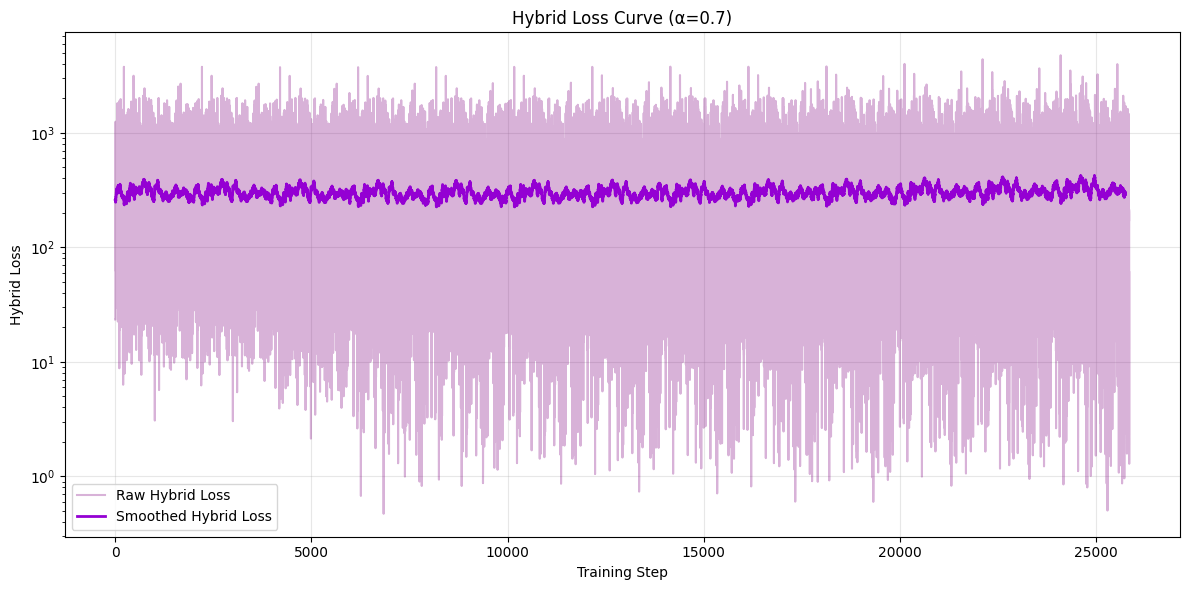

Plotted hybrid loss for 1 source(s) with α=0.7

=== Plotting Complete ===


In [7]:
   
# 4) Hybrid Loss Curve (if available)
print("\n=== Plotting Hybrid Loss ===")

# Extract next token loss data for hybrid calculation
student_next_token_df = combined_df[
    (combined_df["role"] == "student") & 
    (combined_df["train_next_token_loss"].notna())
].copy()

if len(student_next_token_df) > 0 and len(student_kl_df) > 0:
    # Convert train_next_token_loss values to numeric
    next_token_loss_values = []
    for val in student_next_token_df["train_next_token_loss"]:
        if pd.isna(val):
            continue
        try:
            if isinstance(val, str) and "tensor(" in val:
                # Extract float from tensor string
                import re
                match = re.search(r'tensor\(([0-9.]+)', val)
                if match:
                    next_token_loss_values.append(float(match.group(1)))
            else:
                next_token_loss_values.append(float(val))
        except (ValueError, AttributeError):
            continue
    
    # Calculate hybrid loss if we have both components
    if len(next_token_loss_values) > 0 and len(kl_loss_values) > 0:
        # Use the alpha value from the CSV (should be 0.7 based on the sample)
        alpha_vals = combined_df[combined_df["alpha"].notna()]["alpha"].values
        alpha = alpha_vals[0] if len(alpha_vals) > 0 else 0.7
        
        # Make sure arrays are same length (take minimum)
        min_len = min(len(kl_loss_values), len(next_token_loss_values))
        kl_array = np.array(kl_loss_values[:min_len])
        next_token_array = np.array(next_token_loss_values[:min_len])
        
        # Calculate hybrid loss: (1-alpha) * kl_loss + alpha * next_token_loss
        hybrid_loss_array = (1 - alpha) * kl_array + alpha * next_token_array
        
        if len(hybrid_loss_array) > filter_size:
            smoothed = scipy.signal.fftconvolve(hybrid_loss_array, kernel, mode="valid")
            
            plt.figure(figsize=(12, 6))
        
            if len(sources) == 1:
                # Single source - simple plot
                plt.plot(range(len(hybrid_loss_array)), hybrid_loss_array, alpha=0.3, label="Raw Hybrid Loss", color="purple")
                plt.plot(range(len(smoothed)), smoothed, label="Smoothed Hybrid Loss", color="darkviolet", linewidth=2)
            else:
                # Multiple sources - calculate hybrid for each
                for name, source_df in dfs.items():
                    # Get KL and next token loss for this source
                    source_kl_df = source_df[(source_df["role"] == "student") & (source_df["train_kl_loss"].notna())]
                    source_nt_df = source_df[(source_df["role"] == "student") & (source_df["train_next_token_loss"].notna())]
                    
                    if len(source_kl_df) > 0 and len(source_nt_df) > 0:
                        # Extract values for this source
                        source_kl_vals, source_nt_vals = [], []
                        
                        for val in source_kl_df["train_kl_loss"]:
                            if not pd.isna(val):
                                try:
                                    if isinstance(val, str) and "tensor(" in val:
                                        match = re.search(r'tensor\(([0-9.]+)', val)
                                        if match:
                                            source_kl_vals.append(float(match.group(1)))
                                    else:
                                        source_kl_vals.append(float(val))
                                except (ValueError, AttributeError):
                                    continue
                        
                        for val in source_nt_df["train_next_token_loss"]:
                            if not pd.isna(val):
                                try:
                                    if isinstance(val, str) and "tensor(" in val:
                                        match = re.search(r'tensor\(([0-9.]+)', val)
                                        if match:
                                            source_nt_vals.append(float(match.group(1)))
                                    else:
                                        source_nt_vals.append(float(val))
                                except (ValueError, AttributeError):
                                    continue
                        
                        if len(source_kl_vals) > 0 and len(source_nt_vals) > 0:
                            # Calculate hybrid for this source
                            min_len_src = min(len(source_kl_vals), len(source_nt_vals))
                            source_kl_array = np.array(source_kl_vals[:min_len_src])
                            source_nt_array = np.array(source_nt_vals[:min_len_src])
                            source_hybrid = (1 - alpha) * source_kl_array + alpha * source_nt_array
                            
                            if len(source_hybrid) > filter_size:
                                source_smoothed = scipy.signal.fftconvolve(source_hybrid, kernel, mode="valid")
                                color = color_map.get(name, color_map["default"])
                                plt.plot(range(len(source_hybrid)), source_hybrid, alpha=0.2, color=color)
                                plt.plot(range(len(source_smoothed)), source_smoothed, label=f"{name}", color=color, linewidth=2)
            
            plt.title(f"Hybrid Loss Curve (α={alpha})")
            plt.xlabel("Training Step")
            plt.ylabel("Hybrid Loss")
            plt.yscale("log")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            print(f"Plotted hybrid loss for {len(sources)} source(s) with α={alpha}")
        else:
            print(f"Not enough hybrid loss data: {len(hybrid_loss_array)} values")
    else:
        print("Could not calculate hybrid loss - missing component data")
else:
    print("No next token loss data found for hybrid calculation")
    
print("\n=== Plotting Complete ===")

In [8]:
# Metadata display (if available)
try:
    for df_data in dfs.values():
        metadata_rows = df_data[df_data["metadata"].notna()]
        if len(metadata_rows) > 0:
            metadata_str = metadata_rows["metadata"].iloc[0]
            metadata = ast.literal_eval(metadata_str)

            print(f"\n==== METADATA FROM {metadata.get('Custom run name','N/A')} ====")
            print(f"Run ID String: {metadata.get('ID string', 'N/A')}")
            print(f"Run Description: {metadata.get('Description', 'N/A')}\n")

            for key, value in metadata.items():
                print(f"{key}: {value}")
except Exception as e:
    print(f"\nNo metadata available or error reading metadata: {e}")


No metadata available or error reading metadata: 'metadata'



=== Analyzing Learning Rate Curve ===


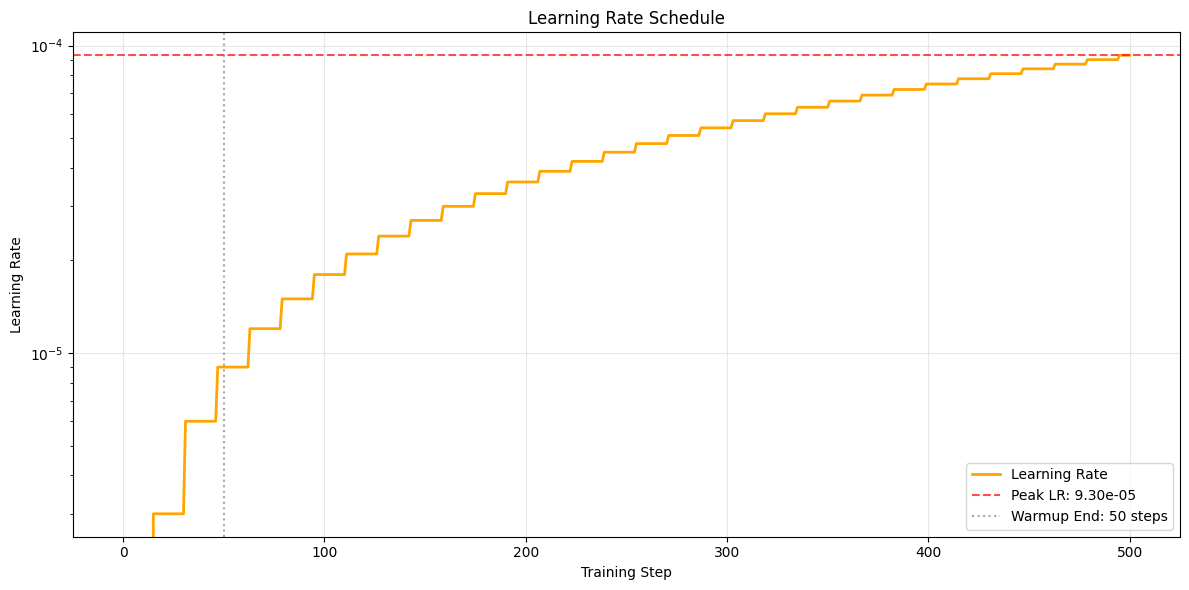

📊 Learning Rate Analysis:
  Peak LR after warmup (step 50+): 9.30e-05 (at step 495)
  Overall max LR: 9.30e-05
  Overall min LR: 0.00e+00
  Total LR data points: 25865

💡 Recommended config.learning_rate: 9.30e-05
   (This should be the original learning_rate config value)


In [12]:
# 5) Learning Rate Curve Analysis
print("\n=== Analyzing Learning Rate Curve ===")

# Extract learning rate data
lr_df = combined_df[
    (combined_df["learning_rate"].notna())
].copy()

if len(lr_df) > 0:
    # Convert learning_rate values to numeric
    lr_values = []
    steps = []
    
    for idx, row in lr_df.iterrows():
        if pd.isna(row["learning_rate"]) or pd.isna(row["step"]):
            continue
        try:
            lr_val = float(row["learning_rate"])
            step_val = int(row["step"])
            lr_values.append(lr_val)
            steps.append(step_val)
        except (ValueError, TypeError):
            continue
    
    if len(lr_values) > 10:
        lr_array = np.array(lr_values)
        steps_array = np.array(steps)
        
        plt.figure(figsize=(12, 6))
    
        if len(sources) == 1:
            # Single source - simple plot
            plt.plot(steps_array, lr_array, label="Learning Rate", color="orange", linewidth=2)
        else:
            # Multiple sources - plot each separately
            for name, source_df in dfs.items():
                source_lr_df = source_df[
                    (source_df["learning_rate"].notna()) & 
                    (source_df["step"].notna())
                ]
                
                if len(source_lr_df) > 0:
                    source_lr_vals, source_steps = [], []
                    for idx, row in source_lr_df.iterrows():
                        try:
                            lr_val = float(row["learning_rate"])
                            step_val = int(row["step"])
                            source_lr_vals.append(lr_val)
                            source_steps.append(step_val)
                        except (ValueError, TypeError):
                            continue
                    
                    if len(source_lr_vals) > 5:
                        color = color_map.get(name, color_map["default"])
                        plt.plot(source_steps, source_lr_vals, label=f"{name}", color=color, linewidth=2)
        
        # Analyze learning rate statistics
        max_lr = np.max(lr_array)
        min_lr = np.min(lr_array)
        
        # Find peak learning rate after warmup (around step 50 based on config)
        warmup_steps = 50
        if len(lr_array) > warmup_steps:
            post_warmup_mask = steps_array >= warmup_steps
            if np.any(post_warmup_mask):
                post_warmup_lr = lr_array[post_warmup_mask]
                peak_lr_after_warmup = np.max(post_warmup_lr)
                peak_step = steps_array[post_warmup_mask][np.argmax(post_warmup_lr)]
            else:
                peak_lr_after_warmup = max_lr
                peak_step = steps_array[np.argmax(lr_array)]
        else:
            peak_lr_after_warmup = max_lr
            peak_step = steps_array[np.argmax(lr_array)]
        
        # Add annotations
        plt.axhline(peak_lr_after_warmup, color="red", linestyle="--", alpha=0.7, 
                   label=f"Peak LR: {peak_lr_after_warmup:.2e}")
        plt.axvline(warmup_steps, color="gray", linestyle=":", alpha=0.7, 
                   label=f"Warmup End: {warmup_steps} steps")
        
        plt.title("Learning Rate Schedule")
        plt.xlabel("Training Step")
        plt.ylabel("Learning Rate")
        plt.yscale("log")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print analysis results
        print(f"📊 Learning Rate Analysis:")
        print(f"  Peak LR after warmup (step {warmup_steps}+): {peak_lr_after_warmup:.2e} (at step {peak_step})")
        print(f"  Overall max LR: {max_lr:.2e}")
        print(f"  Overall min LR: {min_lr:.2e}")
        print(f"  Total LR data points: {len(lr_values)}")
        print(f"")
        print(f"💡 Recommended config.learning_rate: {peak_lr_after_warmup:.2e}")
        print(f"   (This should be the original learning_rate config value)")
        
    else:
        print(f"Not enough learning rate data: {len(lr_values)} values")
else:
    print("No learning rate data found")

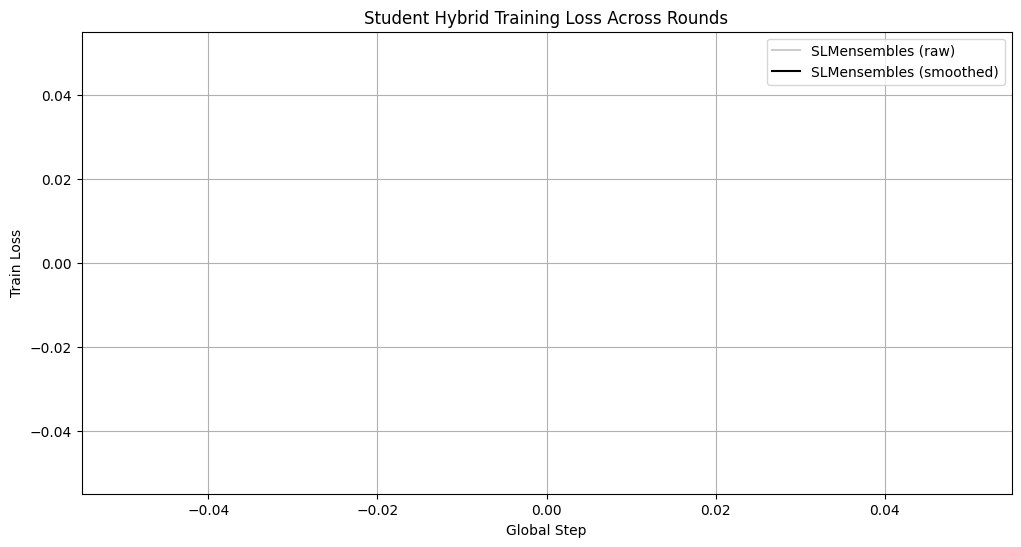

In [9]:
# Student train loss (hybrid) over rounds
side_by_side = False
x_min_loss = False
min_len = 2500

filter_size = 51
kernel = np.ones(filter_size) / filter_size


if not side_by_side:
    # Display values on the x-axis only up to the minimum number of logged lines across files
    if x_min_loss:
        for name, df in combined_df.groupby("source"):
            student_train_df = df[(df["role"] == "student") & (df["phase"] == "train") & (df["function"] == "compute_loss")]

            loss = student_train_df["train_loss"].to_numpy()
            min_len = min(min_len, len(loss))

    plt.figure(figsize=(12, 6))

    for name, df in combined_df.groupby("source"):

        student_train_df = df[(df["role"] == "student") & (df["phase"] == "train") & (df["function"] == "compute_loss")]

        loss = student_train_df["train_loss"].to_numpy()[:min_len]
        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        plt.plot(range(len(loss)), loss, alpha=0.2, label=f"{name} (raw)", color=color)
        plt.plot(range(len(smoothed)), smoothed, label=f"{name} (smoothed)", color=color)

    plt.title("Student Hybrid Training Loss Across Rounds")
    plt.xlabel("Global Step")
    plt.ylabel("Train Loss")
    plt.legend()
    plt.grid(True)
    # plt.yscale("log")
    plt.show()
else:
    num_files = len(dfs)
    cols = min(num_files, 3)
    rows = (num_files + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)

    for idx, (name, df) in enumerate(dfs.items()):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        student_train_df = df[(df["role"] == "student") & (df["phase"] == "train") & (df["function"] == "compute_loss")]

        loss = student_train_df["train_loss"].to_numpy()
        if len(loss) < filter_size:
            ax.set_title(f"{name} (too short)")
            ax.axis("off")
            continue

        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        ax.plot(range(len(loss)), loss, alpha=0.3, label=f"Raw", color=color)
        ax.plot(range(len(smoothed)), smoothed, label=f"Smoothed", color=color)
        
        ax.set_title(f"Training Loss: {name}")
        ax.set_xlabel("Global Step")
        ax.set_ylabel("Train Loss")
        ax.legend()

    # Hide any unused subplots
    for i in range(idx + 1, rows * cols):
        row, col = divmod(i, cols)
        axes[row][col].axis("off")

    plt.yscale("log")
    plt.tight_layout()
    plt.show()

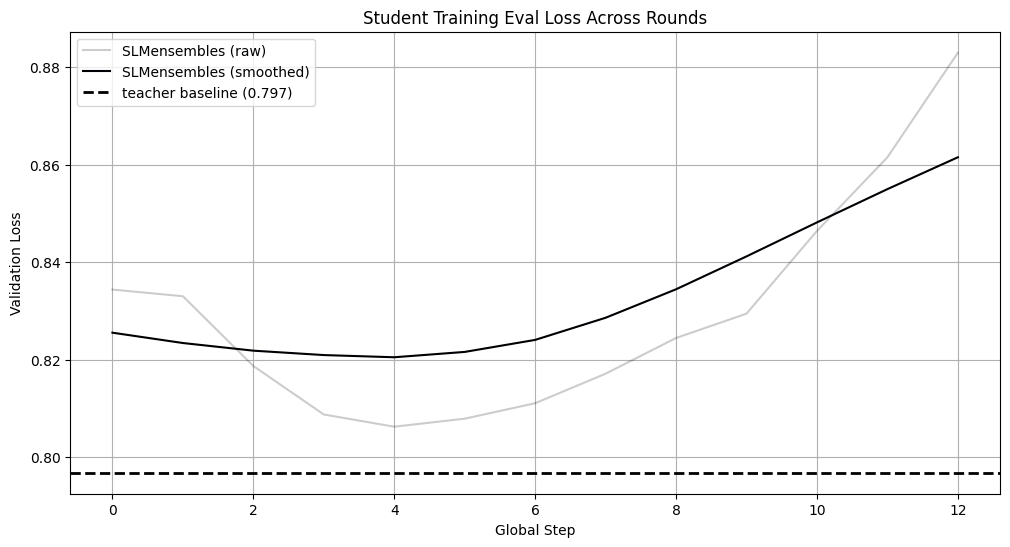

In [10]:
# Student Training Eval Loss Across Rounds

side_by_side = False
x_min_loss = False  # Display values on the x-axis only up to the minimum number of logged lines across files
min_len = 200

filter_size = 11
kernel = np.ones(filter_size) / filter_size

if not side_by_side:
    if x_min_loss:
        for name, df in combined_df.groupby("source"):
            student_train_df = df[(df["role"] == "student") & (df["phase"] == "eval") & (df["function"] == "eval_step")]

            loss = student_train_df["eval_loss"].to_numpy()
            min_len = min(min_len, len(loss))

    plt.figure(figsize=(12, 6))

    for name, df in combined_df.groupby("source"):
        student_train_df = df[(df["role"] == "student") & (df["phase"] == "eval") & (df["function"] == "eval_step")]

        loss = student_train_df["eval_loss"].to_numpy()[:min_len]
        pad = (filter_size - 1) // 2
        padded_loss = np.pad(loss, pad_width=pad, mode="edge")
        smoothed = scipy.signal.fftconvolve(padded_loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        plt.plot(range(len(loss)), loss, alpha=0.2, label=f"{name} (raw)", color=color)
        plt.plot(range(len(smoothed)), smoothed, label=f"{name} (smoothed)", color=color)

    baseline_teacher_loss = 0.7968094515065487
    plt.axhline(baseline_teacher_loss, color="black", linestyle="--", linewidth=2,
                label=f"teacher baseline ({baseline_teacher_loss:.3f})")

    plt.title("Student Training Eval Loss Across Rounds")
    plt.xlabel("Global Step")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    # plt.yscale("log")
    plt.show()
else:
    num_files = len(dfs)
    cols = min(num_files, 3)
    rows = (num_files + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)

    for idx, (name, df) in enumerate(dfs.items()):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        student_train_df = df[(df["role"] == "student") & (df["phase"] == "eval") & (df["function"] == "eval_step")]

        loss = student_train_df["eval_loss"].to_numpy()
        if len(loss) < filter_size:
            ax.set_title(f"{name} (too short)")
            ax.axis("off")
            continue

        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        ax.plot(range(len(loss)), loss, alpha=0.3, label=f"Raw", color=color)
        ax.plot(range(len(smoothed)), smoothed, label=f"Smoothed", color=color)
        
        ax.set_title(f"Validation Loss: {name}")
        ax.set_xlabel("Global Step")
        ax.set_ylabel("Validation Loss")
        ax.legend()

    # Hide any unused subplots
    for i in range(idx + 1, rows * cols):
        row, col = divmod(i, cols)
        axes[row][col].axis("off")

    plt.yscale("log")
    plt.tight_layout()
    plt.show()

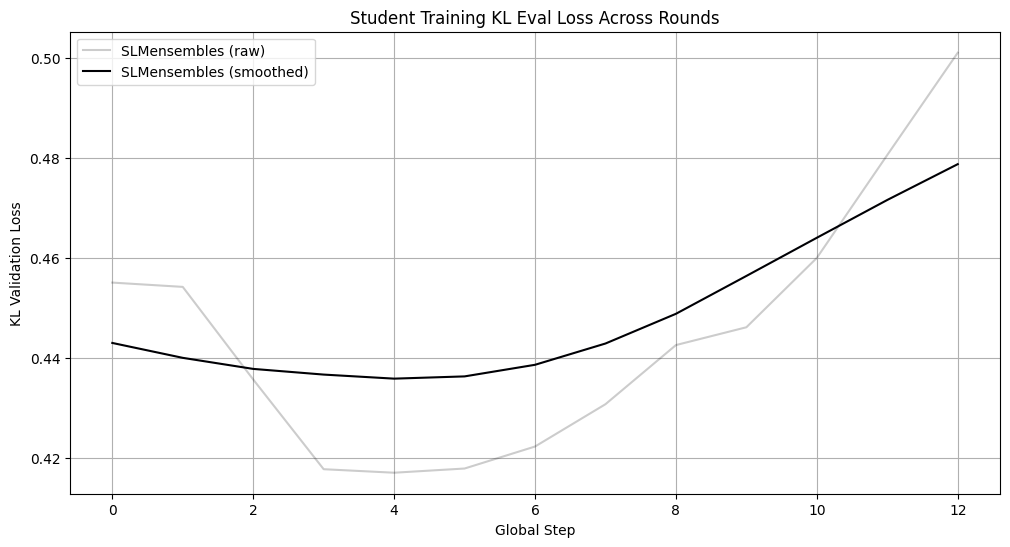

In [11]:


# Student train loss (kl) over rounds
side_by_side = False
x_min_loss = False
min_len = 200

filter_size = 11
kernel = np.ones(filter_size) / filter_size

if not side_by_side:
    # Display values on the x-axis only up to the minimum number of logged lines across files
    if x_min_loss:
        for name, df in combined_df.groupby("source"):
            student_train_df = df[
                (df["role"] == "student") &
                (df["phase"] == "eval") &
                (df["function"] == "eval_step")
            ]

            loss = student_train_df["eval_kl_loss"].to_numpy()
            min_len = min(min_len, len(loss))

    plt.figure(figsize=(12, 6))

    for  name, df in combined_df.groupby("source"):
        student_train_df = df[
            (df["role"] == "student") &
            (df["phase"] == "eval") &
            (df["function"] == "eval_step")
        ]

        loss = student_train_df["eval_kl_loss"].to_numpy()[:min_len]
        pad = (filter_size - 1) // 2
        padded_loss = np.pad(loss, pad_width=pad, mode='edge')
        smoothed = scipy.signal.fftconvolve(padded_loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        plt.plot(range(len(loss)), loss, alpha=0.2, label=f"{name} (raw)", color=color)
        plt.plot(range(len(smoothed)), smoothed, label=f"{name} (smoothed)", color=color)


    plt.title("Student Training KL Eval Loss Across Rounds")
    plt.xlabel("Global Step")
    plt.ylabel("KL Validation Loss")
    plt.legend()
    plt.grid(True)
    # plt.yscale("log")
    plt.show()
else:
    num_files = len(dfs)
    cols = min(num_files, 3)
    rows = (num_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)
    
    for idx, (name, df) in enumerate(dfs.items()):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        student_train_df = df[
            (df["role"] == "student") &
            (df["phase"] == "eval") &
            (df["function"] == "eval_step")
        ]

        loss = student_train_df["eval_kl_loss"].to_numpy()
        if len(loss) < filter_size:
            ax.set_title(f"{name} (too short)")
            ax.axis("off")
            continue

        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        ax.plot(range(len(loss)), loss, alpha=0.3, label=f"Raw", color=color)
        ax.plot(range(len(smoothed)), smoothed, label=f"Smoothed", color=color)
        
        ax.set_title(f"KL Validation Loss: {name}")
        ax.set_xlabel("Global Step")
        ax.set_ylabel("KL Loss")
        ax.legend()

    # Hide any unused subplots
    for i in range(idx + 1, rows * cols):
        row, col = divmod(i, cols)
        axes[row][col].axis("off")
    
    plt.yscale("log")
    plt.tight_layout()
    plt.show()